In [36]:
# be noted on the required versions:lumicks.pylake==0.8.1 tabulate==0.8.6; python 3.9
# python==3.9; jupyterlab==3.0.12; lumicks.pylake==0.8.1; matplotlib==3.3.4; more-itertools==8.7.0;
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
import os
import numpy as np
import lumicks.pylake as lk  
import cv2
import pylab as pl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import collections  as mc
from matplotlib import colors as mcolors
import pandas as pd
from nptdms import TdmsFile
from scipy.signal import savgol_filter
import tifffile as tif
from scipy import interpolate
from scipy.interpolate import interp1d
# %matplotlib widget
%matplotlib inline

In [3]:
# read raw image data of .tdms file with TdmsFile function
# name example: /Users/longfu/Library/CloudStorage/Dropbox/4-T7DNAp-SSB_NSMB/Figure2_imaging data_collected_Feb &Nov_2020_analyzed_May2023/1-Thesis writing analyzing 20 molecules_23may2023/20200121-012_typical data analysis/raw data/image data/20200121-140146 6nM gp2.5-atto647N + 144nM wt gp2.5 + 30nM DNAp and etal #012-001.tdms
kymo_filename = input('please type in the file name:' )

please type in the file name: example data analysis/image data/20200121-140146 6nM gp2.5-atto647N + 144nM wt gp2.5 + 30nM DNAp and etal #012-001.tdms


In [4]:
kymo_cycle = str('#') + input('please type in the processing cycle(e.g: 1):' )

please type in the processing cycle(e.g: 1): 01


In [5]:
# access .tdms file and convert .tdms to image data
metadata = TdmsFile.read_metadata(kymo_filename)
# print(metadata.properties)
width = metadata.properties['Pixels per line']
px_size = float(metadata.properties['Scan Command.Scan Command.scanning_axes.0.pix_size_nm'])
px_dwell_time = float(metadata.properties['Scan Command.PI Fast Scan Command.pixel_dwell_time_ms'])
inter_frame_time = float(metadata.properties['Scan Command.PI Fast Scan Command.inter_frame_wait_time_ms'])

tdms_file = TdmsFile(kymo_filename)
kymo_time = tdms_file['Data']['Time (ms)'][:]
kymo_time = np.array([int(i) for i in kymo_time])
kymo_position = tdms_file['Data']['Actual position X (um)'][:]
kymo_position = np.array([int(i) for i in kymo_position])
height = len(kymo_time)/width
time_per_line = kymo_time[-1]/height # this is calculated by (time_per_line = acquisition time/all lines)

chn_r = tdms_file['Data']['Pixel ch 1'][:]
chn_r = np.array([int(i) for i in chn_r])
chn_g = tdms_file['Data']['Pixel ch 2'][:]
chn_g = np.array([int(i) for i in chn_g])
chn_b = tdms_file['Data']['Pixel ch 3'][:]
chn_b = np.array([int(i) for i in chn_b])

chn_rgb = np.vstack((chn_r, chn_g, chn_b)).T
img = chn_rgb.reshape((int(height), int(width), 3))
img = img.transpose((1, 0, 2))
img = img.astype(np.uint16)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


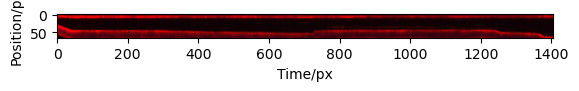

<Figure size 640x480 with 0 Axes>

In [6]:
# show tif image
plt.figure(kymo_filename)
plt.imshow(img.astype('uint16'),vmax = 10)
plt.xlabel('Time/px')
plt.ylabel('Position/px')
plt.show()
plt.tight_layout()

In [6]:
# save .tdms file to tif image
tif.imwrite(kymo_filename + '.tiff', img)

Text(0, 0.5, 'Position/px')

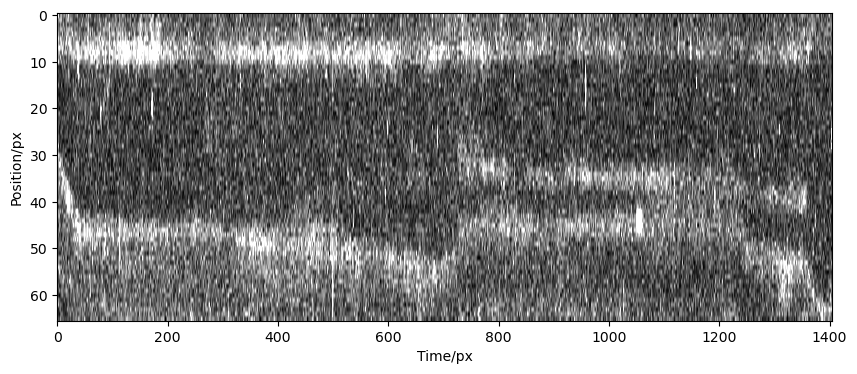

In [7]:
# Plot DNA polymerase from image data
b,g,r = cv2.split(img)

# the kymograph can be plotted in a normal image or in a reverse black-white image
vmax =7
fig, ax=plt.subplots(figsize=(10,4))
ax.imshow(g.astype('uint16'),cmap='gray',vmax = vmax,aspect ="auto")
# plt.imshow(100-g.astype('uint16'),cmap='gray',vmin = 95,aspect ="auto")

plt.xlabel("Time/px")
plt.ylabel("Position/px")
# plt.title("DNA Polymerase on ssDNA")

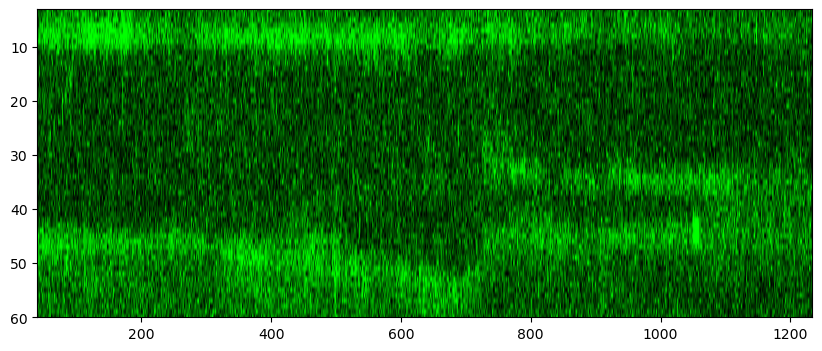

In [8]:
# Normalize the green channel by vmax
g_normalized = (g / vmax) * 255
g_normalized[g_normalized > 255] = 255

# Create a new image with only the green channel information
green_image = np.zeros_like(img)
green_image[:, :, 1] = g_normalized.astype(np.uint16)

# Plot the green image
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(cv2.cvtColor(green_image, cv2.COLOR_BGR2RGB), aspect="auto")

# this number defines the ROI (region of interest) of image in px; should be tuned to properly display the image
kymo_xlim_left = 40
kymo_xlim_right = 1234
kymo_ylim_top = 3
kymo_ylim_bottom = 60

ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)

plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + '-splited_channel_green'+'.eps', format='eps', dpi=300, bbox_inches='tight')

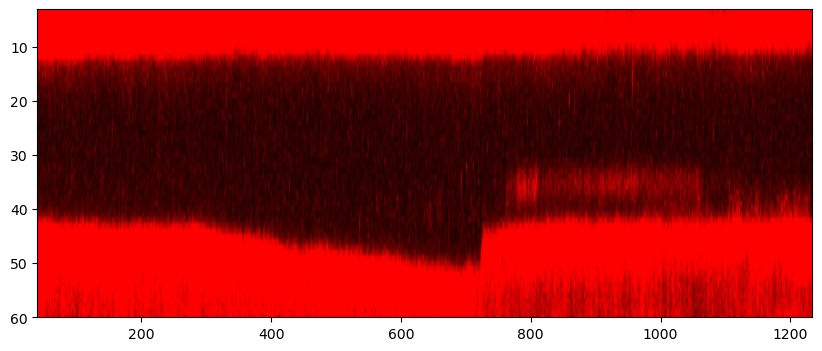

<Figure size 640x480 with 0 Axes>

In [9]:
# Normalize the red channel by vmax
vmax_red = 75
r_normalized = (b / vmax_red) * 255
r_normalized[r_normalized > 255] = 255

# Create a new image with only the red channel information
red_image = np.zeros_like(img)
red_image[:, :, 2] = r_normalized.astype(np.uint16)

# Plot the red image
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(cv2.cvtColor(red_image, cv2.COLOR_BGR2RGB), aspect="auto")

# this number defines the ROI (region of interest) of image in px; should be tuned to properly display the image
kymo_xlim_left = 40
kymo_xlim_right = 1234
kymo_ylim_top = 3
kymo_ylim_bottom = 60

ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)
plt.show()
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + '-splited_channel_red'+'.eps', format='eps', dpi=300, bbox_inches='tight')

In [10]:
# read and plot the DNA trace calculated from force measurement (1_CalculatingDNApTrace_OT.py)

trace_file = input('please type in the file name:' )
# example name: /Users/longfu/Library/CloudStorage/Dropbox/4-T7DNAp-SSB_NSMB/Figure2_imaging data_collected_Feb &Nov_2020_analyzed_May2023/1-Thesis writing analyzing 20 molecules_23may2023/20200121-012_typical data analysis/raw data/force measurement/20200121-140145  6nM gp2.5-atto647N + 144nM wt gp2.5 + 30nM DNAp and etal #012-002-cycle#1processedData.xlsx
trace = pd.read_excel(trace_file)
# trace = pd.read_excel(trace_file, engine='openpyxl')
print(trace.head())

please type in the file name: example data analysis/force data/20200121-140145  6nM gp2.5-atto647N + 144nM wt gp2.5 + 30nM DNAp and etal #012-002-cycle#01processedData.xlsx


   Unnamed: 0  time  ssDNA_all_percentage  junction_position_all    basepairs
0           0  6897              0.017736               2.829670  8244.140152
1           1  6946              0.019431               2.824788  8229.917526
2           2  6996              0.017569               2.830152  8245.544152
3           3  7047              0.017992               2.828932  8241.990529
4           4  7096              0.020327               2.822207  8222.396769


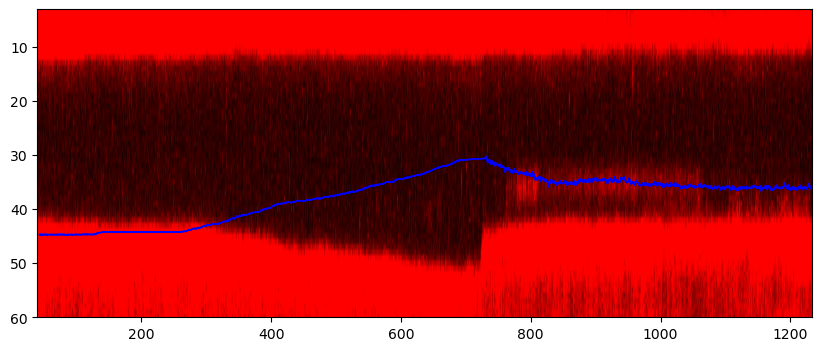

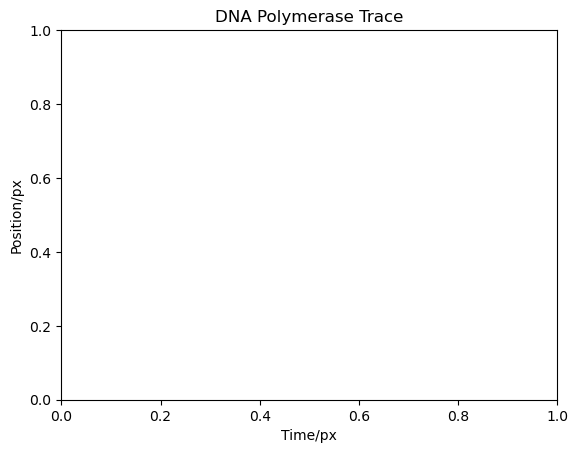

In [13]:
# the following step is intended to plot the DNA junction on top of DNAp trajectory
# The time of image is used for reference and displayed
# Tune x_offset and y_offset to get the proper alignment
plt.figure(figsize=(8,6))
plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.title("DNA Polymerase Trace")
x_offset_searching = -23 # this is done by align starting time in pixel （larger absolute value moves to left）
y_offset_searching = 7 # this is done by align starting position in pixel 
x_cali = 1000/time_per_line  # this is calculated by (1s/time per line， e.g.：163.8ms)
y_cali = 1000/px_size # this is calculated by (1um/pixel size, in this case pixlsize = 75nm)
trace_time = trace['time']/1000 * x_cali + x_offset_searching
trace_time = trace_time.dropna()
position = pd.to_numeric(trace['junction_position_all'], errors='coerce') 
position = position * y_cali + y_offset_searching
position = position.dropna()

plt.plot(trace_time,position,'blue',linewidth = 1, label = 'first trial correlation')
# plt.ylim(25,85)
# plt.legend()

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_DNAp_image_with_color'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_DNAp_image_with_color'+'.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

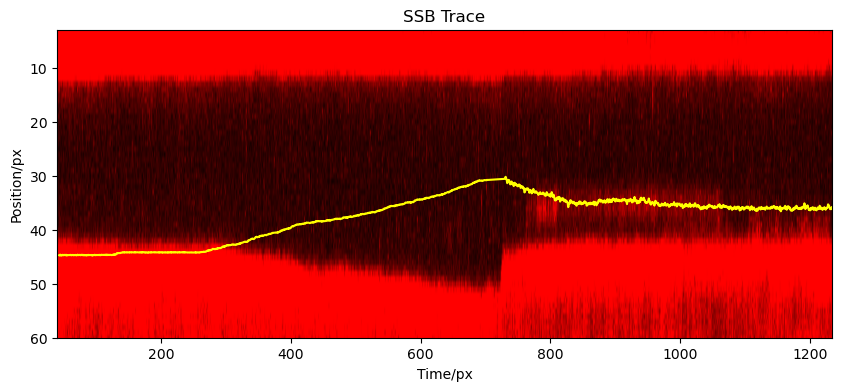

In [14]:
# the following step is intended to plot the DNA junction on top of DNAp trajectory
# The time of image is used for reference and displayed

# Normalize the red channel by vmax
r_normalized = (b / vmax_red) * 255
r_normalized[r_normalized > 255] = 255

# Create a new image with only the red channel information
red_image = np.zeros_like(img)
red_image[:, :, 2] = r_normalized.astype(np.uint16)

# Plot the red image
fig, ax = plt.subplots(figsize=(10, 4))
ax.imshow(cv2.cvtColor(red_image, cv2.COLOR_BGR2RGB), aspect="auto")
ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)

plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.title("SSB Trace")

ax.plot(trace_time,position,'yellow',linewidth = 1.5, label = 'first trial correlation')
# plt.ylim(25,85)

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_SSB_image_with_color'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_SSB_image_with_color'+'.png', format='png', dpi=300, bbox_inches='tight')

# We started to detect the SSB trajectory

Text(0, 0.5, 'Position/px')

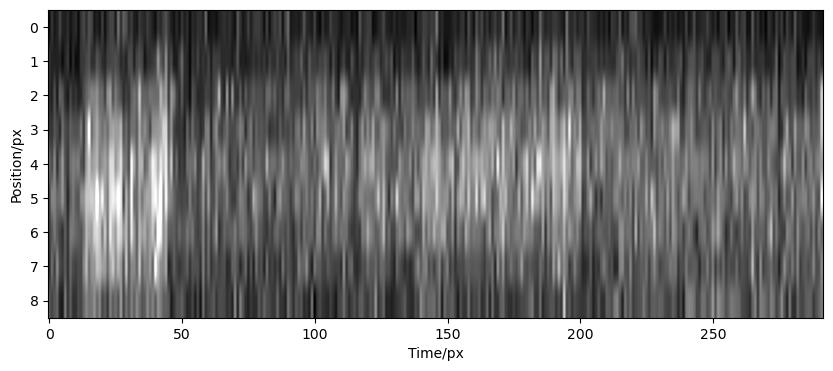

In [15]:
# Coordinates of the region of interest (ROI) of the original image
roi_start_y, roi_end_y = 31, 40
roi_start_x, roi_end_x = 766, 1058

# The ROI image
b_ROI = b[roi_start_y:roi_end_y, roi_start_x:roi_end_x] 

# the kymograph can be plotted in a normal image or in a reverse black-white image
vmax =75
fig, ax=plt.subplots(figsize=(10,4))
ax.imshow(b_ROI.astype('uint16'),cmap='gray',vmax = vmax,aspect ="auto")
# plt.imshow(100-g.astype('uint16'),cmap='gray',vmin = 95,aspect ="auto")

plt.xlabel("Time/px")
plt.ylabel("Position/px")

In [16]:
# check the original document on how to use this method: https://lumicks-pylake.readthedocs.io/en/v0.8.2/tutorial/kymotracking.html
traces = lk.track_greedy(b_ROI, line_width=5, pixel_threshold=25, window=6)
traces = lk.filter_lines(traces, 3)
traces = lk.refine_lines_centroid(traces, line_width=5)
print(len(traces))
# traces.save(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + '-SSB-trajectory' + '.csv')

1


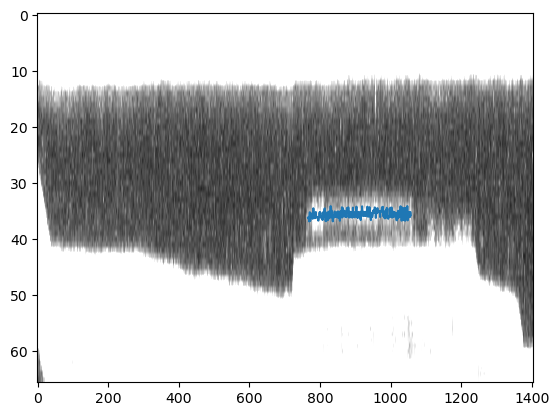

In [17]:
# Plotting the trajectories on the original image
plt.figure()
plt.imshow(b, aspect="auto", vmax=50, cmap='gray')
for trace in traces:
    plt.plot(np.array(trace.time_idx) + roi_start_x, np.array(trace.coordinate_idx) + roi_start_y)

plt.show()

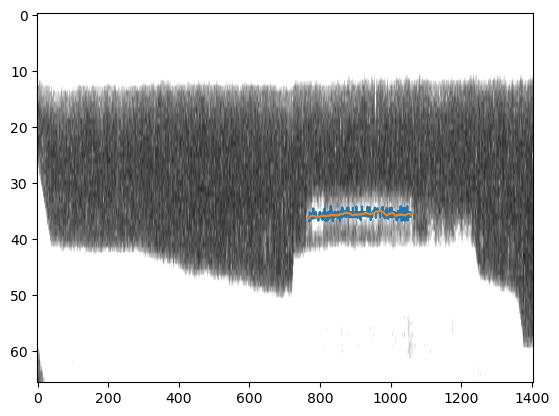

In [19]:
# Parameters for the Savitzky-Golay filter
# you might want to tune the window size to get optimal results
window_size = 31  # Must be odd and greater than the polynomial order
poly_order = 3

plt.figure()
plt.imshow(b, aspect="auto", vmax=50, cmap='gray')
for trace in traces:
    plt.plot(np.array(trace.time_idx) + roi_start_x, np.array(trace.coordinate_idx) + roi_start_y)
    
for trace in traces:
    time_idx_smooth = savgol_filter(np.array(trace.time_idx), window_size, poly_order)
    coordinate_idx_smooth = savgol_filter(np.array(trace.coordinate_idx), window_size, poly_order)
    plt.plot(time_idx_smooth + roi_start_x, coordinate_idx_smooth + roi_start_y)

plt.show()

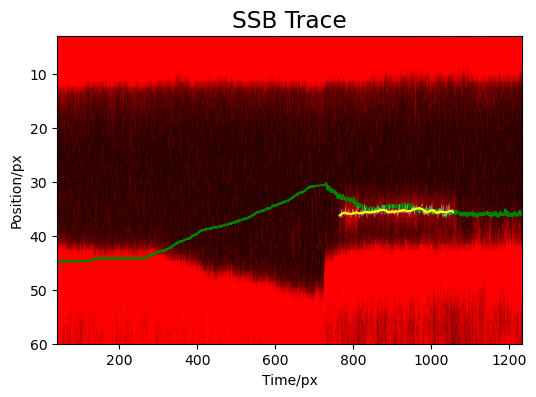

<Figure size 640x480 with 0 Axes>

In [20]:
# the following step is intended to plot the DNAp traces on top of SSB trajectory, together with the detected SSB trajectory

fig, ax = plt.subplots(figsize=(6, 4))
# Customize plot appearance
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

# Plot the SSB image with red color
# Normalize the red channel by vmax
r_normalized = (b / vmax_red) * 255
r_normalized[r_normalized > 255] = 255

# Create a new image with only the red channel information
red_image = np.zeros_like(img)
red_image[:, :, 2] = r_normalized.astype(np.uint16)

ax.imshow(cv2.cvtColor(red_image, cv2.COLOR_BGR2RGB), aspect="auto")
ax.set_xlim(kymo_xlim_left,kymo_xlim_right)
ax.set_ylim(kymo_ylim_bottom,kymo_ylim_top)

plt.xlabel("Time/px")
plt.ylabel("Position/px")
plt.title("SSB Trace")

# plot the DNAP traces
ax.plot(trace_time,position,'green',linewidth = 1.5)

for trace in traces:
    time_idx_smooth = savgol_filter(np.array(trace.time_idx), window_size, poly_order)
    coordinate_idx_smooth = savgol_filter(np.array(trace.coordinate_idx), window_size, poly_order)
    plt.plot(np.array(trace.time_idx) + roi_start_x, np.array(trace.coordinate_idx) + roi_start_y, 'lightgray', linewidth = 0.2)
    plt.plot(time_idx_smooth + roi_start_x, coordinate_idx_smooth + roi_start_y, "yellow",linewidth = 1.5 )

plt.show()

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_DNAp+SSB_detected Traje'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'overlapped_DNAp+SSB_detected Traje'+'.png', format='png', dpi=300, bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


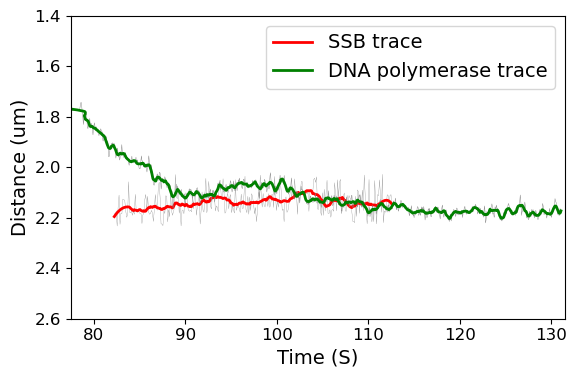

In [21]:
# now let's plot the DNAp with detected SSB trajectory without fluorescence image, while converting back to time (s)
fig, ax = plt.subplots(figsize=(6, 4))
# Customize plot appearance
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

for trace in traces:
    # Convert the pixel coordinates back to s and um
    time_idx_smooth_s = (time_idx_smooth + roi_start_x - x_offset_searching) / x_cali
    coordinate_idx_smooth_um = (coordinate_idx_smooth + roi_start_y - y_offset_searching) / y_cali
    plt.plot((np.array(trace.time_idx) + roi_start_x- x_offset_searching) / x_cali, (np.array(trace.coordinate_idx) + roi_start_y- y_offset_searching) / y_cali, 'gray', linewidth = 0.2)
    plt.plot(time_idx_smooth_s, coordinate_idx_smooth_um,"red",linewidth = 2,label = "SSB trace")

# Converting the DNAP line from pixels to s and um
trace_time_s = (np.array(trace_time) - x_offset_searching) / x_cali
position_um = (np.array(position) - y_offset_searching) / y_cali

# Plotting the reference line
trace_time_s_filter = savgol_filter(np.array(trace_time_s), window_length=21, polyorder=3)
position_um_filter = savgol_filter(np.array(position_um), window_length=21, polyorder=3)
ax.plot(trace_time_s, position_um, 'gray', linewidth = 0.3)
ax.plot(trace_time_s_filter,position_um_filter,'green',linewidth= 2, label = "DNA polymerase trace")

ax.set_xlim(77.5,131.5)
ax.set_ylim(1.4,2.6)

ax.invert_yaxis()

plt.xlabel("Time (S)")
plt.ylabel("Distance (um)")
plt.legend()
plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'detected_DNAp+SSB'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'detected_DNAp+SSB'+'.png', format='png', dpi=300, bbox_inches='tight')

plt.show()


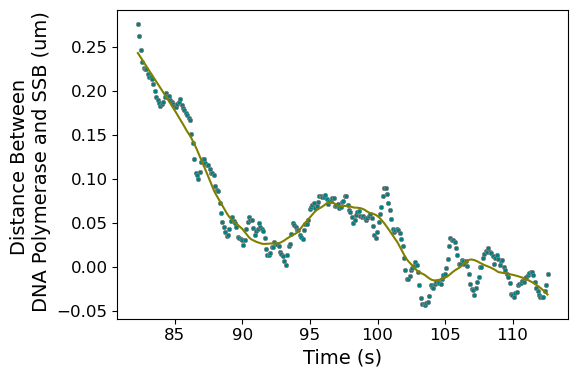

In [22]:
# now let's calculate the distance between filtered DNAp and filtered SSB

# Create subplots
fig, ax = plt.subplots(figsize=(6, 4))
# Customize plot appearance
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

# Create interpolation function for the DNAP traces, as the SSB has lower resolution
interp_DNAp = interp1d(trace_time_s_filter, position_um_filter)

# Calculate y-value differences; the difference should be adjusted based on the relative position of DNAp and SSB to get positive values
position_diff = -(interp_DNAp(time_idx_smooth_s) - coordinate_idx_smooth_um)
# position_diff = (interp_DNAp(time_idx_smooth_s) - coordinate_idx_smooth_um)

# Plot the y-value difference as a function of time
ax.scatter(time_idx_smooth_s, position_diff, c='teal', marker='o', edgecolors='gray', linewidths=0.5, s=10)
ax.plot(savgol_filter(time_idx_smooth_s, 71, 3), savgol_filter(position_diff, 71, 3),'olive', linewidth = 1.5)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Distance Between \n DNA Polymerase and SSB (um)')
# ax.set_xlim(77.5,131.5)
plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'distance_between_DNAp+SSB'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'distance_between_DNAp+SSB'+'.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

# Let's plot each of the SSB traces in indivisual subplot, and calculate the distance

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


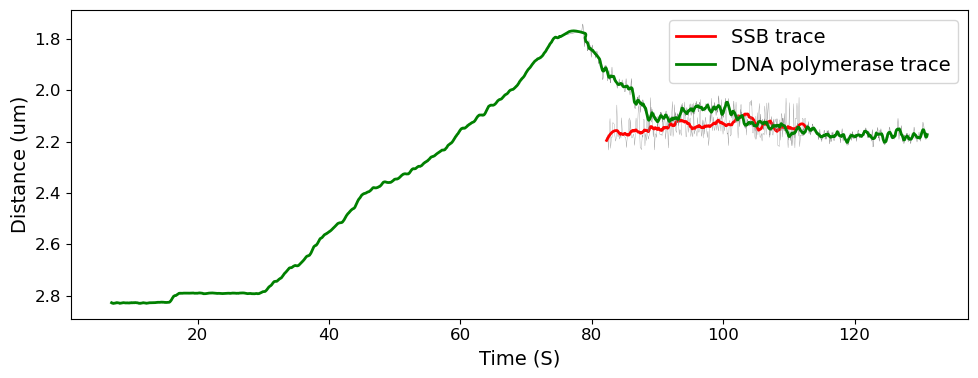

In [30]:
# Converting the reference line from pixels to s and um
trace_time_s = (np.array(trace_time) - x_offset_searching) / x_cali
position_um = (np.array(position) - y_offset_searching) / y_cali

# Get the number of traces
n_traces = len(traces)

# Create subplots
fig, axs = plt.subplots(n_traces, figsize=(10, 4*n_traces))
# Customize plot appearance
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

for i, trace in enumerate(traces):
    time_idx_smooth = savgol_filter(np.array(trace.time_idx), window_size, poly_order)
    coordinate_idx_smooth = savgol_filter(np.array(trace.coordinate_idx), window_size, poly_order)

    # Convert the pixel coordinates back to s and um
    time_idx_smooth_s = (time_idx_smooth + roi_start_x - x_offset_searching) / x_cali
    coordinate_idx_smooth_um = (coordinate_idx_smooth + roi_start_y - y_offset_searching) / y_cali

    # If only one trace, axs is not an array
    if n_traces == 1:
        ax = axs
    else:
        ax = axs[i]
    ax.plot((np.array(trace.time_idx) + roi_start_x- x_offset_searching) / x_cali, (np.array(trace.coordinate_idx) + roi_start_y- y_offset_searching) / y_cali, 'gray', linewidth = 0.2)
    ax.plot(time_idx_smooth_s, coordinate_idx_smooth_um,"red",linewidth = 2,label = "SSB trace")
    ax.invert_yaxis()
    
    # Plotting the DNAp traces
    ax.plot(trace_time_s, position_um, 'gray', linewidth = 0.3)
    ax.plot(trace_time_s_filter,position_um_filter,'green',linewidth= 2, label = "DNA polymerase trace")

plt.xlabel("Time (S)")
plt.ylabel("Distance (um)")
plt.legend()
plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'all_traces_DNAp+SSB'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'all_traces_DNAp+SSB'+'.png', format='png', dpi=300, bbox_inches='tight')
    
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


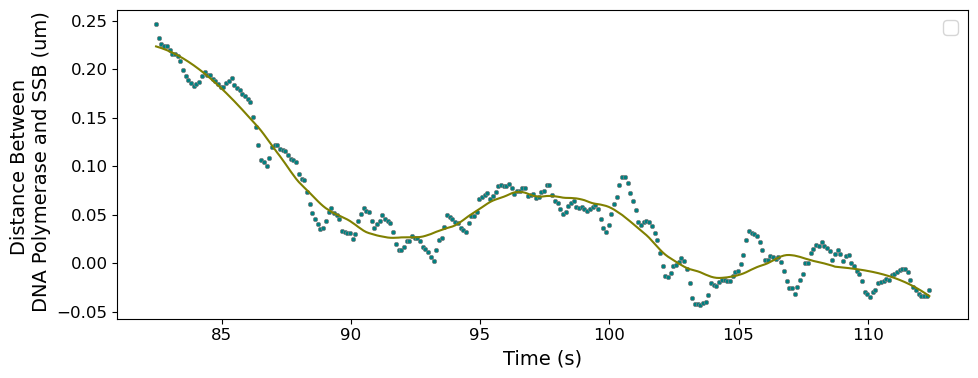

In [34]:

# Create interpolation function for the reference line
interp_DNAp = interp1d(trace_time_s, position_um)

# Get the number of traces
n_traces = len(traces)

# Create subplots
fig, axs = plt.subplots(n_traces, figsize=(10, 4*n_traces))
# Customize plot appearance
plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 14})
plt.rcParams.update({'xtick.labelsize': 12})
plt.rcParams.update({'ytick.labelsize': 12})

for i, trace in enumerate(traces):
    # Create interpolation function for the DNAP traces, as the SSB has lower resolution
    interp_DNAp = interp1d(trace_time_s_filter, position_um_filter)

    # Calculate y-value differences; the difference should be adjusted based on the relative position of DNAp and SSB to get positive values
    position_diff = -(interp_DNAp(time_idx_smooth_s) - coordinate_idx_smooth_um)
    # position_diff = (interp_DNAp(time_idx_smooth_s) - coordinate_idx_smooth_um)

    # If only one trace, axs is not an array
    if n_traces == 1:
        ax = axs
    else:
        ax = axs[i]

    # Plot the y-value difference as a function of time
    ax.scatter(time_idx_smooth_s, position_diff, c='teal', marker='o', edgecolors='gray', linewidths=0.5, s=10)
    ax.plot(savgol_filter(time_idx_smooth_s, 71, 3), savgol_filter(position_diff, 71, 3),'olive', linewidth = 1.5)
    

plt.xlabel('Time (s)')
plt.ylabel('Distance Between \n DNA Polymerase and SSB (um)')
plt.legend()
plt.tight_layout()

plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'all_distances_DNAp+SSB'+'.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'all_distances_DNAp+SSB'+'.png', format='png', dpi=300, bbox_inches='tight')
   
plt.show()

In [38]:
# save all the data in separate csv files for easy retrieval later
# Define a directory for saving the CSV files
save_dir = kymo_filename.replace('.tdms', '-cycle#') + kymo_cycle + 'analyzed data'

import os

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the reference trace
df_DNAp = pd.DataFrame({'time_s': trace_time_s, 'position_um': position_um, 'time_s_filter': trace_time_s_filter,'position_um_filter': position_um_filter})
df_DNAp.to_csv(os.path.join(save_dir, 'DNAp_trace.csv'), index=False)

# Save each SSB trace and the corresponding y-value differences
for i, trace in enumerate(traces):

    # Create a DataFrame and save it as a CSV file
    df_trace = pd.DataFrame({
        'time_s': time_idx_smooth_s,
        'position_um': coordinate_idx_smooth_um,
        'position_diff_um': position_diff
    })
    df_trace.to_csv(os.path.join(save_dir, f'trace_{i}.csv'), index=False)